<a href="https://colab.research.google.com/github/TizianoCosta/AML_2425_FinalProject/blob/main/notebook/regressione_logistica_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook per regressione lineare

Di seguito:
- verrà implementato l'algoritmo di regressione logistica

## Scaricamento dei dati

In [1]:
# File per scaricare i dati per fare analisi di machine learning

import requests
import zipfile
import io
import os

# List of URLs to your zipped files on AWS
urls = [
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip"]

# Directory to save the extracted files
output_dir = "dataset"
os.makedirs(output_dir, exist_ok=True)

for url in urls:
    try:
        print(f"Downloading {url}...")
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes

        # Read the zip file from the response content
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Extract all contents to the specified output directory
            zip_ref.extractall(output_dir)
            print(f"Extracted files from {url} to {output_dir}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except zipfile.BadZipFile:
        print(f"Error: The downloaded file from {url} is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

print("Download and extraction complete.")

# Now you can access your CSV files in the 'downloaded_data' directory
# For example, to list the files in the directory:
import glob
csv_files = glob.glob(os.path.join(output_dir, "*.csv"))
print("CSV files found:", csv_files)

Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to dataset
Download and extraction complete.
CSV files found: ['dataset/X_train.csv', 'dataset/y_train.csv']


## Estrazione dei dati

In [2]:
import pandas as pd

def load_data(x_path, y_path):
  """
  Loads X.csv and the second column of y.csv into a single pandas DataFrame.

  Args:
    x_path (str): The path to the X.csv file.
    y_path (str): The path to the y.csv file.

  Returns:
    pandas.DataFrame: A DataFrame containing the data from X.csv
                      and the second column of y.csv.
  """
  x = pd.read_csv(x_path)
  y = pd.read_csv(y_path)

  # Assuming y has at least 2 columns and the second column is at index 1
  if y.shape[1] > 1:
    combined_data = x.copy()
    combined_data['y_target'] = y.iloc[:, 1]
    return combined_data
  else:
    print("Error: y.csv does not have a second column.")
    return x

# Example usage:
# Assuming your files are in the 'dataset' directory as per the preceding code
x_path = 'dataset/X_train.csv'
y_path = 'dataset/y_train.csv'

data = load_data(x_path, y_path)

# You can now work with the 'data' DataFrame
print(data.head())


   id  trq_measured       oat       mgt         pa       ias         np  \
0   0        54.100   2.00000  544.5000   212.1408  74.56250   89.18000   
1   1        49.625  24.22231  578.4844  1625.6400  30.35596   99.55273   
2   2        52.000   7.00000  566.1000  1912.9250  65.62500  100.14000   
3   3        62.400   7.25000  560.1000   277.0632  54.81250   90.64000   
4   4        62.900  23.25000  593.7000    53.6448  73.43750   99.91000   

         ng  y_target  
0   99.6400         1  
1   91.3866         0  
2   90.9600         1  
3  100.2800         0  
4   92.1700         0  


## Creazione training-set testing-set

In [3]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

print("Dimensione data_train:", data_train.shape)
print("Dimensione data_test:", data_test.shape)

Dimensione data_train: (594100, 9)
Dimensione data_test: (148525, 9)


# PIPELINE

## Cambio nome delle feature

In [4]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class FeatureRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        if not isinstance(column_names, list):
            raise TypeError("column_names must be a list.")
        self.column_names = column_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        is_tuple = isinstance(X, tuple)
        if is_tuple:
            if not X:
                raise ValueError("Input tuple is empty.")
            df = X[0]
            rest = X[1:]
        else:
            df = X
            rest = ()

        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input (or first element if tuple) must be a DataFrame.")

        # Drop 'id' column if present
        if 'id' in df.columns:
            df = df.drop(columns='id')

        # Check column count matches
        if len(self.column_names) != df.shape[1]:
            if len(self.column_names) + 1 == df.shape[1] and 'faulty' in df.columns:
                print("Detected 'faulty' column, adjusting rename.")
                new_cols = self.column_names + ['faulty']
                if len(new_cols) != df.shape[1]:
                    raise ValueError("Mismatch in column count with 'faulty' included.")
                df_renamed = df.copy()
                df_renamed.columns = new_cols
            else:
                raise ValueError("Column count mismatch after dropping 'id'.")
        else:
            df_renamed = df.copy()
            df_renamed.columns = self.column_names

        return (df_renamed,) + rest if rest else df_renamed

# ---------------------- Setup ----------------------
new_names_for_train_data = [
    'torque_meas', 'outside_air_temp', 'mean_gas_temp',
    'power_avail', 'indicated_air_speed', 'net_power',
    'compressor_speed', 'health_state'
]

# ---------------------- Pipeline ----------------------
pipeline_with_renaming = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data))
])

# Apply pipeline
data_train_renamed = pipeline_with_renaming.fit_transform(data_train)

# ---------------------- Output ----------------------
print("Renamed DataFrame (without 'id'):")
print(data_train_renamed.head())

Renamed DataFrame (without 'id'):
        torque_meas  outside_air_temp  mean_gas_temp  power_avail  \
331067      74.8000            19.500       646.1000    1005.8400   
601458      67.0332            20.152       602.4063     958.4962   
77053       67.8000             8.000       546.7000      24.3840   
664037      53.9000             5.500       532.1000     360.8832   
346977      73.3000            17.750       636.3000    1025.9570   

        indicated_air_speed  net_power  compressor_speed  health_state  
331067             56.00000  100.19000          96.47000             1  
601458             96.97656   99.65235          94.02332             0  
77053              73.68750  100.22000          91.61000             0  
664037             61.87500   88.91000          99.78000             0  
346977             89.50000   99.98000          95.95000             1  


## Standardizzazione

In [5]:
from sklearn.preprocessing import MinMaxScaler

def standardize_columns(df, columns_to_standardize):
  """
  Standardizes specified columns of a pandas DataFrame to have values between 0 and 1
  using MinMaxScaler.

  Args:
    df: The pandas DataFrame to standardize.
    columns_to_standardize: A list of column names to standardize.

  Returns:
    The DataFrame with the specified columns standardized.
  """
  scaler = MinMaxScaler()
  df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
  return df

# Example usage:
# Assuming you want to standardize all numerical columns except the index and the target variable
# Identify numerical columns (excluding 'idx' and 'health_state' in this case)
numerical_cols = data_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
columns_to_standardize = [col for col in numerical_cols if col not in ['idx', 'health_state']]

print(f"\nColumns to standardize: {columns_to_standardize}")

data_train_standardized = standardize_columns(data_train.copy(), columns_to_standardize)

print("\nDataFrame after standardization:")
print(data_train_standardized.head())
print("\nDescriptive statistics after standardization:")
print(data_train_standardized.describe())


Columns to standardize: ['id', 'trq_measured', 'oat', 'mgt', 'pa', 'ias', 'np', 'ng', 'y_target']

DataFrame after standardization:
              id  trq_measured       oat       mgt        pa       ias  \
331067  0.445807      0.667650  0.691358  0.698165  0.367293  0.407088   
601458  0.809909      0.581407  0.702990  0.527553  0.352972  0.704964   
77053   0.103758      0.589922  0.486181  0.310035  0.070412  0.535666   
664037  0.894177      0.435575  0.441577  0.253026  0.172200  0.449796   
346977  0.467231      0.650994  0.660135  0.659898  0.373378  0.650613   

              np        ng  y_target  
331067  0.930147  0.576580       1.0  
601458  0.897203  0.358480       0.0  
77053   0.931985  0.143354       0.0  
664037  0.238971  0.871637       0.0  
346977  0.917279  0.530226       1.0  

Descriptive statistics after standardization:
                  id   trq_measured            oat            mgt  \
count  594100.000000  594100.000000  594100.000000  594100.000000   
mea

In [6]:
# prompt: crea una classe che sia compatibile con l'oggetto pipeline di scikit che contenga la funzione transform_with_custom_root standardize_columns

class ColumnStandardizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_standardize=None):
        self.columns_to_standardize = columns_to_standardize
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a DataFrame.")

        if self.columns_to_standardize is None:
            # Identify numerical columns excluding the target if present
            numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
            # Assuming 'y_target' or similar is the target and should not be scaled
            # This part might need adjustment based on how your pipeline handles the target column
            self._cols_to_fit = [col for col in numerical_cols if col not in ['y_target', 'health_state']] # Exclude common target/index names
        else:
             if not isinstance(self.columns_to_standardize, (list, tuple)):
                 raise TypeError("columns_to_standardize must be a list or tuple of column names.")
             # Ensure all specified columns exist in the input DataFrame
             missing_cols = [col for col in self.columns_to_standardize if col not in X.columns]
             if missing_cols:
                 raise ValueError(f"Columns not found in input DataFrame: {missing_cols}")
             self._cols_to_fit = self.columns_to_standardize

        if not self._cols_to_fit:
            print("Warning: No columns selected for standardization.")
            return self

        # Fit the scaler only on the selected numerical columns
        self.scaler.fit(X[self._cols_to_fit])
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a DataFrame.")
        if not hasattr(self, '_cols_to_fit'):
             raise RuntimeError("The transformer has not been fitted yet.")

        df_standardized = X.copy()

        if not self._cols_to_fit:
             return df_standardized # Return original if no columns to standardize

        # Ensure that the columns to transform are actually present in the input DataFrame
        present_cols_to_transform = [col for col in self._cols_to_fit if col in df_standardized.columns]

        if not present_cols_to_transform:
             print("Warning: None of the specified columns for standardization are present in the input DataFrame.")
             return df_standardized

        # Transform only the present columns
        df_standardized[present_cols_to_transform] = self.scaler.transform(df_standardized[present_cols_to_transform])

        return df_standardized


## Dropping columns

In [7]:
# prompt: crea una trasformazione che droppi certe colonne di un dataset

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        if not isinstance(columns_to_drop, (list, tuple)):
            raise TypeError("columns_to_drop must be a list or tuple of column names.")
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        # Nothing to fit, but check if columns exist in the input
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a DataFrame.")
        missing_cols = [col for col in self.columns_to_drop if col not in X.columns]
        if missing_cols:
            print(f"Warning: Columns to drop not found in input DataFrame: {missing_cols}. These will be ignored during transform.")
            # Store the columns that are actually present to avoid errors during transform
            self._cols_to_drop_present = [col for col in self.columns_to_drop if col in X.columns]
        else:
            self._cols_to_drop_present = self.columns_to_drop
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a DataFrame.")
        if not hasattr(self, '_cols_to_drop_present'):
             raise RuntimeError("The transformer has not been fitted yet.")

        df_dropped = X.copy()
        # Drop only the columns that were found during fit
        df_dropped = df_dropped.drop(columns=self._cols_to_drop_present, errors='ignore')
        return df_dropped

## Radice custom

### Trasformazione in work_with_data

In [8]:
def transform_with_custom_root(df, column_name, root_degree):
  """
  Applies a custom root transformation (1/root_degree power) to a column.
  Handles positive, negative, and zero values appropriately based on the root degree.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.
    root_degree (float): The degree of the root (e.g., 2 for square root, 3 for cube root).

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  new_column_name = f'{column_name}_root_{root_degree:.2f}_transformed'

  if root_degree == 0:
      raise ValueError("Root degree cannot be zero.")
  elif root_degree % 2 == 0:  # Even root
      # For even roots, we can only take the root of non-negative numbers
      if (df[column_name] < 0).any():
          print(f"Warning: Column '{column_name}' contains negative values. Cannot apply even root directly.")
          # You might choose to handle this by taking the root of the absolute value,
          # or setting negative values to NaN, depending on your data context.
          # Here, we'll take the root of the absolute value for demonstration.
          df[new_column_name] = np.power(np.abs(df[column_name]), 1/root_degree)
      else:
          df[new_column_name] = np.power(df[column_name], 1/root_degree)
  else:  # Odd root
      # Odd roots can handle positive, negative, and zero values
      df[new_column_name] = np.sign(df[column_name]) * np.power(np.abs(df[column_name]), 1/root_degree)

  return df

### Trasformazione pipeline

In [9]:
# prompt: crea una classe che sia compatibile con l'oggetto pipeline di scikit che contenga la funzione transform_with_custom_root

class CustomRootTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, root_transformations=None):
        self.root_transformations = root_transformations

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        df_transformed = X.copy()

        if self.root_transformations:
            for col, deg in self.root_transformations.items():
                if col not in df_transformed.columns:
                    # print(f"Warning: Column '{col}' not found in DataFrame. Skipping root transformation.") # Silence this
                    continue

                # print(f"Applying custom root {deg} transformation to column '{col}'...") # Silence this
                # Use the existing transform_with_custom_root function but handle its potential print
                # A more robust way would be to modify transform_with_custom_root itself
                # For this case, we assume transform_with_custom_root doesn't print excessively
                # or we accept its prints for now. To strictly silence, you'd need to redirect stdout.
                df_transformed = transform_with_custom_root(df_transformed, col, deg)

        return df_transformed



In [139]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer

def transform_with_quantile_transformer(df, column_name, output_distribution='normal'):
  """
  Applies a quantile transformation to a specified column to make its distribution
  more Gaussian-like (normal) or uniform.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.
    output_distribution (str): The desired output distribution. 'normal'
                               for Gaussian-like, 'uniform' for uniform.
                               Default is 'normal'.

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  if column_name not in df.columns:
    raise ValueError(f"La colonna '{column_name}' non è presente nel DataFrame.")

  # Reshape the data as the transformer expects a 2D array
  data_to_transform = df[column_name].values.reshape(-1, 1)

  # Initialize and fit the QuantileTransformer
  quantile_transformer = QuantileTransformer(output_distribution=output_distribution)
  transformed_data = quantile_transformer.fit_transform(data_to_transform)

  # Add the transformed data back to the DataFrame with a new column name
  df[f'{column_name}_quantile_transformed'] = transformed_data

  return df

# Apply the quantile transformation to the 'power_avail' column
data_train = transform_with_quantile_transformer(data_train.copy(), 'power_avail', output_distribution='normal')

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train['power_avail'], kde=True)
plt.title('Original "power_avail" Distribution')
plt.xlabel('power_avail')
plt.ylabel('Frequency')

# Transformed histogram (Quantile Transformed)
plt.subplot(1, 2, 2)
sns.histplot(data_train['power_avail_quantile_transformed'], kde=True)
plt.title('Quantile Transformed "power_avail" Distribution')
plt.xlabel('"power_avail" (Quantile Transformed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for original and quantile transformed 'power_avail':")
print(data_train[['power_avail', 'power_avail_quantile_transformed']].describe())

ValueError: La colonna 'power_avail' non è presente nel DataFrame.

## Quantile transformer

In [141]:
# prompt: crea una classe che sia compatibile con l'oggetto pipeline di scikit che contenga la funzione transform_with_quantile_transformer

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer

class QuantileTransformerWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_transform, output_distribution='normal'):
        """
        Initializes the QuantileTransformerWrapper.

        Args:
          columns_to_transform (list): A list of column names to transform.
          output_distribution (str): The desired output distribution. 'normal'
                                     for Gaussian-like, 'uniform' for uniform.
                                     Default is 'normal'.
        """
        if not isinstance(columns_to_transform, (list, tuple)):
            raise TypeError("columns_to_transform must be a list or tuple of column names.")
        self.columns_to_transform = columns_to_transform
        self.output_distribution = output_distribution
        self.transformers = {} # Dictionary to store transformers for each column

    def fit(self, X, y=None):
        """
        Fits a QuantileTransformer for each specified column.

        Args:
          X (pd.DataFrame): The input DataFrame.
          y: Ignored.

        Returns:
          self: The fitted transformer.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        for col in self.columns_to_transform:
            if col not in X.columns:
                print(f"Warning: Column '{col}' not found in DataFrame during fit. Skipping.")
                continue

            # Initialize and fit the QuantileTransformer for the current column
            transformer = QuantileTransformer(output_distribution=self.output_distribution)
            transformer.fit(X[col].values.reshape(-1, 1))
            self.transformers[col] = transformer

        return self

    def transform(self, X):
        """
        Applies the fitted QuantileTransformer to the specified columns.

        Args:
          X (pd.DataFrame): The input DataFrame.

        Returns:
          pd.DataFrame: The DataFrame with the transformed columns.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")
        if not hasattr(self, 'transformers'):
            raise RuntimeError("The transformer has not been fitted yet.")

        df_transformed = X.copy()

        for col, transformer in self.transformers.items():
            if col in df_transformed.columns:
                # Apply the transformation
                transformed_data = transformer.transform(df_transformed[col].values.reshape(-1, 1))
                # Add the transformed data back to the DataFrame with a new column name
                df_transformed[f'{col}_quantile_transformed'] = transformed_data
            else:
                 print(f"Warning: Column '{col}' not found in DataFrame during transform. Skipping.")


        return df_transformed


## Binary transformation

### Trasformazione work_with_data

In [10]:
def create_binned_qualitative_variable(df, column_name, num_bins, strategy='quantile'):
  """
  Creates a qualitative (categorical) variable by binning a numerical column.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the numerical column to bin.
    num_bins (int): The desired number of bins.
    strategy (str): The strategy to use for binning. 'quantile' uses quantiles
                    to ensure bins have approximately equal numbers of observations.
                    'uniform' creates bins with equal widths. Default is 'quantile'.

  Returns:
    pd.DataFrame: The DataFrame with a new qualitative column.
                  The new column name will be f'{column_name}_binned_{num_bins}_{strategy}'.
  """
  if column_name not in df.columns:
    raise ValueError(f"La colonna '{column_name}' non è presente nel DataFrame.")
  if num_bins <= 1:
      raise ValueError("Il numero di bins deve essere maggiore di 1.")

  new_column_name = f'{column_name}_binned_{num_bins}_{strategy}'

  if strategy == 'quantile':
    # Use qcut to create bins based on quantiles (approximately equal number of observations)
    # `duplicates='drop'` handles cases where quantile boundaries are not unique,
    # which can happen with skewed or discrete data.
    df[new_column_name] = pd.qcut(df[column_name], q=num_bins, labels=False, duplicates='drop')
  elif strategy == 'uniform':
    # Use cut to create bins of equal width
    df[new_column_name] = pd.cut(df[column_name], bins=num_bins, labels=False, include_lowest=True)
  else:
    raise ValueError(f"Strategia di binning non valida: '{strategy}'. Scegliere tra 'quantile' o 'uniform'.")

  # Convert the binned column to object/category type if needed, or keep as int for simplicity
  # Here we keep it as int representing the bin number

  return df

### Trasformazione pipeline

In [11]:
# prompt: crea una classe che sia compatibile con l'oggetto pipeline di scikit che contenga la funzione  create_binned_qualitative_variable

class BinnedQualitativeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, binning_config=None):
        self.binning_config = binning_config

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        df_transformed = X.copy()

        if self.binning_config:
            for col, (num_bins, strategy) in self.binning_config.items():
                if col not in df_transformed.columns:
                    # print(f"Warning: Column '{col}' not found in DataFrame. Skipping binning transformation.") # Silence this
                    continue

                # print(f"Applying binning transformation to column '{col}' with {num_bins} bins and strategy '{strategy}'...") # Silence this
                df_transformed = create_binned_qualitative_variable(df_transformed, col, num_bins, strategy)

        return df_transformed


## PCA Compressor speed net power

### Trasformazione con work_with_data

In [ ]:
# Select the columns for PCA
features_for_pca = data_train[['compressor_speed', 'net_power']]

# Initialize PCA with 1 component (to combine the two variables)
pca = PCA(n_components=1)

# Fit PCA on the selected features and transform them
data_train['compressor_speed_net_power_pca'] = pca.fit_transform(features_for_pca)

KeyError: "None of [Index(['compressor_speed', 'net_power'], dtype='object')] are in the [columns]"

### Trasformazione pipeline

In [12]:
# prompt: crea una classe che sia compatibile con l'oggetto pipeline di scikit che  come nella cella sopra a partire dalle feature 'compressor_speed' e net_power' tramite il metodo PCA crei una nuova variabile 'compressor_speed_net_power_pca', droppa poi le feature 'net_power' e 'compressor_speed'

class PCATransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_pca, n_components=1, new_column_prefix="pca"):
        if not isinstance(columns_to_pca, list) or len(columns_to_pca) < 1:
            raise ValueError("columns_to_pca must be a list of at least one column name.")
        if n_components < 1 or n_components > len(columns_to_pca):
            raise ValueError("n_components must be between 1 and the number of columns to PCA.")

        self.columns_to_pca = columns_to_pca
        self.n_components = n_components
        self.new_column_prefix = new_column_prefix
        self.pca_model = None
        self.new_column_names = []


    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        missing_cols = [col for col in self.columns_to_pca if col not in X.columns]
        if missing_cols:
            raise ValueError(f"The following columns for PCA were not found in the DataFrame: {missing_cols}")

        # print(f"Fitting PCA on columns: {self.columns_to_pca}") # Silence this
        self.pca_model = PCA(n_components=self.n_components)
        self.pca_model.fit(X[self.columns_to_pca])

        if self.n_components == 1:
            self.new_column_names = [f'{self.new_column_prefix}_{"_".join(self.columns_to_pca).replace(".", "_")}']
        else:
             self.new_column_names = [f'{self.new_column_prefix}_{i+1}' for i in range(self.n_components)]


        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        if self.pca_model is None:
            raise RuntimeError("PCA model has not been fitted yet. Call fit() first.")

        df_transformed = X.copy()

        cols_to_drop_exist = [col for col in self.columns_to_pca if col in df_transformed.columns]

        # print(f"Transforming columns {self.columns_to_pca} using PCA...") # Silence this
        pca_result = self.pca_model.transform(df_transformed[self.columns_to_pca])

        if self.n_components == 1:
             df_transformed[self.new_column_names[0]] = pca_result[:, 0]
        else:
            for i, col_name in enumerate(self.new_column_names):
                df_transformed[col_name] = pca_result[:, i]

        # print(f"Dropping original PCA columns: {cols_to_drop_exist}") # Silence this
        df_transformed = df_transformed.drop(columns=cols_to_drop_exist)

        return df_transformed

## Trasformazione torque_times_temp

### Trasformazione work_with_data

In [ ]:
data_train['torque_times_temp'] = data_train['torque_meas'] * data_train['outside_air_temp']

KeyError: 'torque_meas'

### Trasformazione pipeline

In [13]:
# prompt: crea una classe che sia compatibile con l'oggetto pipeline di scikit che,  come nella cella sopra ,faccia il prodotto dalle feature 'torque_meas' e mean_gas_temp' , e crei  una nuova feature 'torque_times_temp', droppa poi le feature ''torque_meas' e 'mean_gas_temp


class TorqueTempFeature2(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        required_cols = ['torque_meas', 'mean_gas_temp']
        missing_cols = [col for col in required_cols if col not in X.columns]
        if missing_cols:
            raise ValueError(f"The following required columns for TorqueTempFeature were not found in the DataFrame: {missing_cols}")
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        df_transformed = X.copy()

        required_cols = ['torque_meas', 'mean_gas_temp']
        missing_cols = [col for col in required_cols if col not in df_transformed.columns]

        if missing_cols:
             # print(f"Warning: Skipping 'torque_times_temp' creation as columns are missing: {missing_cols}") # Silence this
             return df_transformed
        else:
            # print("Creating 'torque_times_temp' feature...") # Silence this
            df_transformed['torque_times_temp'] = df_transformed['torque_meas'] * df_transformed['mean_gas_temp']
            # print("Dropping 'torque_meas' and 'mean_gas_temp' columns...") # Silence this
            df_transformed = df_transformed.drop(columns=['torque_meas', 'mean_gas_temp'])

        return df_transformed

In [14]:
# prompt: crea una classe che sia compatibile con l'oggetto pipeline di scikit che,  come nella cella sopra ,faccia il prodotto dalle feature 'torque_meas' e outside_air_temp' , e crei  una nuova feature 'torque_times_temp', droppa poi le feature ''torque_meas' e 'outside_air_temp


class TorqueTempFeature(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        required_cols = ['torque_meas', 'outside_air_temp']
        missing_cols = [col for col in required_cols if col not in X.columns]
        if missing_cols:
            raise ValueError(f"The following required columns for TorqueTempFeature were not found in the DataFrame: {missing_cols}")
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        df_transformed = X.copy()

        required_cols = ['torque_meas', 'outside_air_temp']
        missing_cols = [col for col in required_cols if col not in df_transformed.columns]

        if missing_cols:
             # print(f"Warning: Skipping 'torque_times_temp' creation as columns are missing: {missing_cols}") # Silence this
             return df_transformed
        else:
            # print("Creating 'torque_times_temp' feature...") # Silence this
            df_transformed['torque_times_temp'] = df_transformed['torque_meas'] * df_transformed['outside_air_temp']
            # print("Dropping 'torque_meas' and 'outside_air_temp' columns...") # Silence this
            df_transformed = df_transformed.drop(columns=['torque_meas', 'outside_air_temp'])

        return df_transformed

## Tolgo health_state

In [15]:
# prompt: estrai dal dataframe 'data_train' 'helath state' e salvalo in data_train_y e droppalo in data_train

data_train_y = data_train['y_target']
data_train_x = data_train.drop('y_target', axis=1)

print("data_train after dropping 'y_target':")
print(data_train.head())
print("\ndata_train_y (extracted 'y_target'):")
print(data_train_y.head())


data_train after dropping 'y_target':
            id  trq_measured     oat       mgt         pa       ias  \
331067  331067       74.8000  19.500  646.1000  1005.8400  56.00000   
601458  601458       67.0332  20.152  602.4063   958.4962  96.97656   
77053    77053       67.8000   8.000  546.7000    24.3840  73.68750   
664037  664037       53.9000   5.500  532.1000   360.8832  61.87500   
346977  346977       73.3000  17.750  636.3000  1025.9570  89.50000   

               np        ng  y_target  
331067  100.19000  96.47000         1  
601458   99.65235  94.02332         0  
77053   100.22000  91.61000         0  
664037   88.91000  99.78000         0  
346977   99.98000  95.95000         1  

data_train_y (extracted 'y_target'):
331067    1
601458    0
77053     0
664037    0
346977    1
Name: y_target, dtype: int64


# Creazione Pipeline

## Prima Pipeline

In [16]:
import numpy as np
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

In [17]:
import numpy as np
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Update the pipeline to include the new transformations
preprocessing = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data[:-1])), # Exclude 'health_state' if not in data_train_x
    ('custom_root_power_avail', CustomRootTransformer(root_transformations={'power_avail': 2.35})),
    ('binned_air_speed', BinnedQualitativeTransformer(binning_config={'indicated_air_speed': (5, 'quantile')})),
    ('pca_speed_power', PCATransformer(columns_to_pca=['net_power', 'compressor_speed'], n_components=1)),
    ('torque_temp_feature', TorqueTempFeature()),
    ('drop_columns', ColumnDropper(columns_to_drop=['indicated_air_speed', 'power_avail'])), # Add ColumnDropper here
    ('scale_data', ColumnStandardizer(columns_to_standardize=[
        'mean_gas_temp',
        'pca_net_power_compressor_speed',
        'torque_times_temp',
        'power_avail_root_2.35_transformed'])),
  # Assuming you still want scaling at the end
])

# Apply the updated pipeline to data_train_x
data_train_processed_x = preprocessing.fit_transform(data_train_x)

data_train_processed_x

,mean_gas_temp,power_avail_root_2.35_transformed,indicated_air_speed_binned_5_quantile,pca_net_power_compressor_speed,torque_times_temp
331067,0.698165,0.711213,1,0.740530,0.644852
601458,0.527553,0.701660,2,0.804122,0.623529
77053,0.310035,0.337392,1,0.909594,0.463536
664037,0.253026,0.544911,1,0.187028,0.414863
346977,0.659898,0.715194,2,0.750318,0.613678
...,...,...,...,...,...
259178,0.424834,0.437827,1,0.926165,0.634740
365838,0.474034,0.404683,2,0.279659,0.399555
131932,0.746193,0.542934,3,0.461816,0.400550
671155,0.491678,0.899106,2,0.847034,0.394653


## Applicando anche il Onehotencoding

In [18]:
# prompt: prendi esempio dalla cella sopra m, ma esegui anche one_hot_encoding su indicated_air_speed_binned_5_quantile

import pandas as pd
# Update the pipeline to include the new transformations and OneHotEncoder
preprocessing_OH = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data[:-1])), # Exclude 'health_state' if not in data_train_x
    ('custom_root_power_avail', CustomRootTransformer(root_transformations={'power_avail': 2.35})),
    ('binned_air_speed', BinnedQualitativeTransformer(binning_config={'indicated_air_speed': (5, 'quantile')})),
    ('pca_speed_power', PCATransformer(columns_to_pca=['net_power', 'compressor_speed'], n_components=1)),
    ('torque_temp_feature', TorqueTempFeature()),
    # The ColumnDropper should now drop the original 'indicated_air_speed' and 'power_avail'
    ('drop_columns', ColumnDropper(columns_to_drop=['indicated_air_speed', 'power_avail'])),
    # Standardize numerical columns (including the new ones)
    # Note: 'indicated_air_speed_binned_5_quantile' is categorical and will be handled by OneHotEncoder
    ('scale_data', ColumnStandardizer(columns_to_standardize=[
        'mean_gas_temp',
        'pca_net_power_compressor_speed',
        'torque_times_temp',
        'power_avail_root_2.35_transformed'])),
    # Apply OneHotEncoder to the binned categorical column
    ('one_hot_encode_binned_air_speed', ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['indicated_air_speed_binned_5_quantile']) # sparse_output=False to get a dense array
        ],
        remainder='passthrough' # Keep other columns (the scaled numerical ones)
    ))
])

# Apply the updated pipeline to data_train_x
# The output of ColumnTransformer is a numpy array when remainder='passthrough'
data_train_processed_x_array_OH = preprocessing_OH.fit_transform(data_train_x)






### Trasformo in dataframe i dati eleborati

In [92]:
# prompt: trasforma i dati di data_train_processed_x_array_OH in un  data_frame con i nomi delle feature corrispondenti non printare

import pandas as pd
def to_dataframe(preprocessing, data_train_x):


  data_train_processed_x_array = preprocessing.fit_transform(data_train_x)


  column_transformer_step = preprocessing.named_steps['one_hot_encode_binned_air_speed']


  pipeline_before_onehot = Pipeline(preprocessing.steps[:-1])


  df_before_onehot = pipeline_before_onehot.fit_transform(data_train_x)


  onehot_cols_to_encode = column_transformer_step.transformers[0][2]


  remainder_cols = [col for col in df_before_onehot.columns if col not in onehot_cols_to_encode]


  fitted_onehot_transformer = column_transformer_step.named_transformers_['onehot']
  onehot_feature_names = fitted_onehot_transformer.get_feature_names_out(onehot_cols_to_encode)


  all_feature_names = list(onehot_feature_names) + remainder_cols

  data_train_processed = pd.DataFrame(data_train_processed_x_array, columns=all_feature_names)

  return data_train_processed


data_train_processed_OH = to_dataframe(preprocessing_OH, data_train_x)

data_train_processed_OH.index = data_train_x.index


## Tenendo outside_air_temp e torque_meas

In [93]:
# prompt: prendi esempio dalla cella sopra m, ma esegui anche one_hot_encoding su indicated_air_speed_binned_5_quantile

import pandas as pd
# Update the pipeline to include the new transformations and OneHotEncoder
preprocessing_OH_OT = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data[:-1])), # Exclude 'health_state' if not in data_train_x
    ('custom_root_power_avail', CustomRootTransformer(root_transformations={'power_avail': 2.35})),
    ('binned_air_speed', BinnedQualitativeTransformer(binning_config={'indicated_air_speed': (5, 'quantile')})),
    ('pca_speed_power', PCATransformer(columns_to_pca=['net_power', 'compressor_speed'], n_components=1)),
    #('torque_temp_feature', TorqueTempFeature()),
    # The ColumnDropper should now drop the original 'indicated_air_speed' and 'power_avail'
    ('drop_columns', ColumnDropper(columns_to_drop=['indicated_air_speed', 'power_avail'])),
    # Standardize numerical columns (including the new ones)
    # Note: 'indicated_air_speed_binned_5_quantile' is categorical and will be handled by OneHotEncoder
    ('scale_data', ColumnStandardizer(columns_to_standardize=[
        'mean_gas_temp',
        'pca_net_power_compressor_speed',
        'outside_air_temp',
        'torque_meas',
        'power_avail_root_2.35_transformed',
      ])),
    # Apply OneHotEncoder to the binned categorical column
    ('one_hot_encode_binned_air_speed', ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['indicated_air_speed_binned_5_quantile']) # sparse_output=False to get a dense array
        ],
        remainder='passthrough' # Keep other columns (the scaled numerical ones)
    ))
])

# Apply the updated pipeline to data_train_x
# The output of ColumnTransformer is a numpy array when remainder='passthrough'
data_train_processed_x_array_OH_OT = preprocessing_OH_OT.fit_transform(data_train_x)



### Trasformo in dataframe i dati eleborati

In [129]:
# prompt: trasforma i dati di data_train_processed_x_array_OH_OT in un  data_frame con i nomi delle feature corrispondenti non printare

data_train_processed_OH_OT = to_dataframe(preprocessing_OH_OT, data_train_x)

data_train_processed_OH_OT.index = data_train_x.index

data_train_processed_OH_OT

,indicated_air_speed_binned_5_quantile_0,indicated_air_speed_binned_5_quantile_1,indicated_air_speed_binned_5_quantile_2,indicated_air_speed_binned_5_quantile_3,indicated_air_speed_binned_5_quantile_4,torque_meas,outside_air_temp,mean_gas_temp,power_avail_root_2.35_transformed,pca_net_power_compressor_speed
331067,0.0,1.0,0.0,0.0,0.0,0.667650,0.691358,0.698165,0.711213,0.740530
601458,0.0,0.0,1.0,0.0,0.0,0.581407,0.702990,0.527553,0.701660,0.804122
77053,0.0,1.0,0.0,0.0,0.0,0.589922,0.486181,0.310035,0.337392,0.909594
664037,0.0,1.0,0.0,0.0,0.0,0.435575,0.441577,0.253026,0.544911,0.187028
346977,0.0,0.0,1.0,0.0,0.0,0.650994,0.660135,0.659898,0.715194,0.750318
...,...,...,...,...,...,...,...,...,...,...
259178,0.0,1.0,0.0,0.0,0.0,0.462225,0.789486,0.424834,0.437827,0.926165
365838,0.0,0.0,1.0,0.0,0.0,0.532180,0.405894,0.474034,0.404683,0.279659
131932,0.0,0.0,0.0,1.0,0.0,0.742047,0.392513,0.746193,0.542934,0.461816
671155,0.0,0.0,1.0,0.0,0.0,0.496782,0.401805,0.491678,0.899106,0.847034


## Applicando feature engineering su torque e mean_temp

## Quantile transformer su power available

In [156]:
# prompt: prendi esempio dalla cella sotto ma invece di  CustomRootTransformer usa Quantiletransformer

# Update the pipeline to include the new transformations and OneHotEncoder
preprocessing_OH_QT = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data[:-1])), # Exclude 'health_state' if not in data_train_x
    #('custom_root_power_avail', CustomRootTransformer(root_transformations={'power_avail': 2.35})), # Remove custom root
    ('quantile_power_avail', QuantileTransformerWrapper(columns_to_transform=['power_avail'], output_distribution='normal')), # Add QuantileTransformer
    ('binned_air_speed', BinnedQualitativeTransformer(binning_config={'indicated_air_speed': (5, 'quantile')})),
    ('pca_speed_power', PCATransformer(columns_to_pca=['net_power', 'compressor_speed'], n_components=1)),
    # The ColumnDropper should now drop the original 'indicated_air_speed', 'power_avail', 'torque_meas', and 'mean_gas_temp'
    ('drop_columns', ColumnDropper(columns_to_drop=['indicated_air_speed', 'power_avail'])),
    # Standardize numerical columns (including the new ones)
    # Note: 'indicated_air_speed_binned_5_quantile' is categorical and will be handled by OneHotEncoder
    # Note: 'power_avail_quantile_transformed' is now the transformed column
    # Note: 'torque_times_temp' is the new combined feature
    ('scale_data', ColumnStandardizer(columns_to_standardize=[
        'mean_gas_temp', # Dropped
        'pca_net_power_compressor_speed',
        'outside_air_temp',
        'torque_meas', # Dropped
        #'power_avail_root_2.35_transformed', # Removed
        'power_avail_quantile_transformed', # New transformed column
      ])),
    # Apply OneHotEncoder to the binned categorical column
    ('one_hot_encode_binned_air_speed', ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['indicated_air_speed_binned_5_quantile']) # sparse_output=False to get a dense array
        ],
        remainder='passthrough' # Keep other columns (the scaled numerical ones)
    ))
])

# Apply the updated pipeline to data_train_x
# The output of ColumnTransformer is a numpy array when remainder='passthrough'
data_train_processed_x_array_OH_OT_QT = preprocessing_OH_OT_QT.fit_transform(data_train_x)


In [157]:
# prompt: trasforma i dati di data_train_processed_x_array_OH_OT in un  data_frame con i nomi delle feature corrispondenti non printare

data_train_processed_OH_QT = to_dataframe(preprocessing_OH_QT, data_train_x)

data_train_processed_OH_QT.index = data_train_x.index

data_train_processed_OH_QT

,indicated_air_speed_binned_5_quantile_0,indicated_air_speed_binned_5_quantile_1,indicated_air_speed_binned_5_quantile_2,indicated_air_speed_binned_5_quantile_3,indicated_air_speed_binned_5_quantile_4,torque_meas,outside_air_temp,mean_gas_temp,power_avail_quantile_transformed,pca_net_power_compressor_speed
331067,0.0,1.0,0.0,0.0,0.0,0.667650,0.691358,0.698165,0.584702,0.740530
601458,0.0,0.0,1.0,0.0,0.0,0.581407,0.702990,0.527553,0.582945,0.804122
77053,0.0,1.0,0.0,0.0,0.0,0.589922,0.486181,0.310035,0.399820,0.909594
664037,0.0,1.0,0.0,0.0,0.0,0.435575,0.441577,0.253026,0.506883,0.187028
346977,0.0,0.0,1.0,0.0,0.0,0.650994,0.660135,0.659898,0.586238,0.750318
...,...,...,...,...,...,...,...,...,...,...
259178,0.0,1.0,0.0,0.0,0.0,0.462225,0.789486,0.424834,0.434748,0.926165
365838,0.0,0.0,1.0,0.0,0.0,0.532180,0.405894,0.474034,0.421812,0.279659
131932,0.0,0.0,0.0,1.0,0.0,0.742047,0.392513,0.746193,0.504646,0.461816
671155,0.0,0.0,1.0,0.0,0.0,0.496782,0.401805,0.491678,0.736989,0.847034


# Visualizzazione delle pipeline

## Training and Evaluating on the Training Set

In [83]:
from sklearn.linear_model import LogisticRegression

log_reg = make_pipeline(preprocessing, LogisticRegression())
log_reg.fit(data_train_x, data_train_y)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('rename_features',
                                  FeatureRenamer(column_names=['torque_meas',
                                                               'outside_air_temp',
                                                               'mean_gas_temp',
                                                               'power_avail',
                                                               'indicated_air_speed',
                                                               'net_power',
                                                               'compressor_speed'])),
                                 ('custom_root_power_avail',
                                  CustomRootTransformer(root_transformations={'power_avail': 2.35})),
                                 ('binned_air_speed',
                                  BinnedQualitativeTransform...
                                                                 'compressor_speed'])),
                                 ('torque_temp_feature', TorqueTempFeature()),
                                 ('drop_columns',
                                  ColumnDropper(columns_to_drop=['indicated_air_speed',
                                                                 'power_avail'])),
                                 ('scale_data',
                                  ColumnStandardizer(columns_to_standardize=['mean_gas_temp',
                                                                             'pca_net_power_compressor_speed',
                                                                             'torque_times_temp',
                                                                             'power_avail_root_2.35_transformed']))])),
                ('logisticregression', LogisticRegression())])

## One_hot_encoding

In [86]:
from sklearn.linear_model import LogisticRegression

log_reg_OH = make_pipeline(preprocessing_OH, LogisticRegression())
log_reg_OH.fit(data_train_x, data_train_y)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('rename_features',
                                  FeatureRenamer(column_names=['torque_meas',
                                                               'outside_air_temp',
                                                               'mean_gas_temp',
                                                               'power_avail',
                                                               'indicated_air_speed',
                                                               'net_power',
                                                               'compressor_speed'])),
                                 ('custom_root_power_avail',
                                  CustomRootTransformer(root_transformations={'power_avail': 2.35})),
                                 ('binned_air_speed',
                                  BinnedQualitativeTransform...
                                  ColumnStandardizer(columns_to_standardize=['mean_gas_temp',
                                                                             'pca_net_power_compressor_speed',
                                                                             'torque_times_temp',
                                                                             'power_avail_root_2.35_transformed'])),
                                 ('one_hot_encode_binned_air_speed',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['indicated_air_speed_binned_5_quantile'])]))])),
                ('logisticregression', LogisticRegression())])

## Tenendo outside air temp e torque_meas

In [87]:
from sklearn.linear_model import LogisticRegression

log_reg_OH_OT = make_pipeline(preprocessing_OH_OT, LogisticRegression())
log_reg_OH_OT.fit(data_train_x, data_train_y)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('rename_features',
                                  FeatureRenamer(column_names=['torque_meas',
                                                               'outside_air_temp',
                                                               'mean_gas_temp',
                                                               'power_avail',
                                                               'indicated_air_speed',
                                                               'net_power',
                                                               'compressor_speed'])),
                                 ('custom_root_power_avail',
                                  CustomRootTransformer(root_transformations={'power_avail': 2.35})),
                                 ('binned_air_speed',
                                  BinnedQualitativeTransform...
                                                                             'pca_net_power_compressor_speed',
                                                                             'outside_air_temp',
                                                                             'torque_meas',
                                                                             'power_avail_root_2.35_transformed'])),
                                 ('one_hot_encode_binned_air_speed',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['indicated_air_speed_binned_5_quantile'])]))])),
                ('logisticregression', LogisticRegression())])

## Quantile transformation

In [158]:
from sklearn.linear_model import LogisticRegression

log_reg_OH_QT = make_pipeline(preprocessing_OH_QT, LogisticRegression())
log_reg_OH_QT.fit(data_train_x, data_train_y)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('rename_features',
                                  FeatureRenamer(column_names=['torque_meas',
                                                               'outside_air_temp',
                                                               'mean_gas_temp',
                                                               'power_avail',
                                                               'indicated_air_speed',
                                                               'net_power',
                                                               'compressor_speed'])),
                                 ('quantile_power_avail',
                                  QuantileTransformerWrapper(columns_to_transform=['power_avail'])),
                                 ('binned_air_speed',
                                  BinnedQualitativeTransformer(...
                                                                             'pca_net_power_compressor_speed',
                                                                             'outside_air_temp',
                                                                             'torque_meas',
                                                                             'power_avail_quantile_transformed'])),
                                 ('one_hot_encode_binned_air_speed',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['indicated_air_speed_binned_5_quantile'])]))])),
                ('logisticregression', LogisticRegression())])

# Valutazione performance al variare delle trasformazione nella pipeline

## Senza onehotencoding

In [117]:
# prompt: calcola l'accurcay, precision, sensitivity e specificity della regressione logistica dopo aver elaborato i dati tramite pipeline

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming log_reg is your fitted pipeline and data_test is your test DataFrame
# Separate features (X_test) and target (y_test) from the test set
data_test_y = data_test['y_target']
data_test_x = data_test.drop('y_target', axis=1)

# Make predictions on the test set
y_pred = log_reg.predict(data_test_x)

# Calculate the confusion matrix
cm = confusion_matrix(data_test_y, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
accuracy = accuracy_score(data_test_y, y_pred)
precision = precision_score(data_test_y, y_pred)
sensitivity = recall_score(data_test_y, y_pred) # Sensitivity is also known as Recall
# Specificity: TN / (TN + FP)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 # Handle potential division by zero

print("Confusion Matrix:")
print(cm)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


Confusion Matrix:
[[76100 12547]
 [16466 43412]]

Accuracy: 0.8047
Precision: 0.7758
Sensitivity (Recall): 0.7250
Specificity: 0.8585


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


## Con onehotencoding

In [118]:
# prompt: calcola l'accurcay, precision, sensitivity e specificity della regressione logistica dopo aver elaborato i dati tramite pipeline

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming log_reg is your fitted pipeline and data_test is your test DataFrame
# Separate features (X_test) and target (y_test) from the test set
data_test_y = data_test['y_target']
data_test_x = data_test.drop('y_target', axis=1)

# Make predictions on the test set
y_pred = log_reg_OH.predict(data_test_x)

# Calculate the confusion matrix
cm = confusion_matrix(data_test_y, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
accuracy = accuracy_score(data_test_y, y_pred)
precision = precision_score(data_test_y, y_pred)
sensitivity = recall_score(data_test_y, y_pred) # Sensitivity is also known as Recall
# Specificity: TN / (TN + FP)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 # Handle potential division by zero

print("Confusion Matrix:")
print(cm)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Confusion Matrix:
[[77285 11362]
 [14982 44896]]

Accuracy: 0.8226
Precision: 0.7980
Sensitivity (Recall): 0.7498
Specificity: 0.8718


 Noto un miglioramento su tutti gli  indici. È opportuno utilzzare onehotencoding

## Tenendo outside_air_temp e torque_meas

In [122]:
# prompt: calcola l'accurcay, precision, sensitivity e specificity della regressione logistica dopo aver elaborato i dati tramite pipeline

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming log_reg is your fitted pipeline and data_test is your test DataFrame
# Separate features (X_test) and target (y_test) from the test set
data_test_y = data_test['y_target']
data_test_x = data_test.drop('y_target', axis=1)

# Make predictions on the test set
y_pred = log_reg_OH_OT.predict(data_test_x)

# Calculate the confusion matrix
cm = confusion_matrix(data_test_y, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
accuracy = accuracy_score(data_test_y, y_pred)
precision = precision_score(data_test_y, y_pred)
sensitivity = recall_score(data_test_y, y_pred) # Sensitivity is also known as Recall
# Specificity: TN / (TN + FP)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 # Handle potential division by zero

print("Confusion Matrix:")
print(cm)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Confusion Matrix:
[[83192  5455]
 [ 6435 53443]]

Accuracy: 0.9199
Precision: 0.9074
Sensitivity (Recall): 0.8925
Specificity: 0.9385


In [159]:
# prompt: calcola l'accurcay, precision, sensitivity e specificity della regressione logistica dopo aver elaborato i dati tramite pipeline

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming log_reg is your fitted pipeline and data_test is your test DataFrame
# Separate features (X_test) and target (y_test) from the test set
data_test_y = data_test['y_target']
data_test_x = data_test.drop('y_target', axis=1)

# Make predictions on the test set
y_pred = log_reg_OH_QT.predict(data_test_x)

# Calculate the confusion matrix
cm = confusion_matrix(data_test_y, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
accuracy = accuracy_score(data_test_y, y_pred)
precision = precision_score(data_test_y, y_pred)
sensitivity = recall_score(data_test_y, y_pred) # Sensitivity is also known as Recall
# Specificity: TN / (TN + FP)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 # Handle potential division by zero

print("Confusion Matrix:")
print(cm)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Confusion Matrix:
[[83420  5227]
 [ 6341 53537]]

Accuracy: 0.9221
Precision: 0.9111
Sensitivity (Recall): 0.8941
Specificity: 0.9410


Migliorato ulteriormente

## Analisi dei risultati:

La trasformazione che è stata utilizzata in precedenza, che prevedeva la moltiplicazione di 'outside_air_temp' e 'torque_meas', non è ottimale. Infatti ,se si considera la matrice di correlazione, la correlazione tra queste due feature è molto inferiore rispetto a 'torque_meas' e 'mean_gas_temp'. Operando una 'feature_engineering' su queste due feature le prestazioni incrementano notevolmente. È inoltre stato appurato come la trasfomrazione di one_hot_encoding su indicated_air_speed migliori le performance.

# Analisi delle prestazioni del quarto modello

## Cross validation

In [160]:
# prompt: utilizza il cross_val_score per valutaeìre le performance di log_reg_OH_QT

from sklearn.model_selection import cross_val_score

# Evaluate the log_reg_OH_QT pipeline using cross-validation
# We use data_train_x and data_train_y for evaluation with cross-validation,
# as cross_val_score handles the splitting internally.
# Common scoring metrics for classification are 'accuracy', 'precision', 'recall', 'f1'.
# Let's evaluate using accuracy as an example.

# Use the pipeline log_reg_OH_QT directly in cross_val_score
# cross_val_score takes the estimator (your pipeline), the data, and the target.
# cv=... specifies the number of folds for cross-validation.
# scoring='accuracy' specifies the metric to use.
log_reg_OH_QT_scores_accuracy = cross_val_score(log_reg_OH_QT, data_train_x, data_train_y, cv=10, scoring="accuracy")

print("Cross-validation Accuracy Scores (log_reg_OH_QT):", log_reg_OH_QT_scores_accuracy)
print("Mean CV Accuracy (log_reg_OH_QT):", log_reg_OH_QT_scores_accuracy.mean())
print("Standard Deviation of CV Accuracy (log_reg_OH_QT):", log_reg_OH_QT_scores_accuracy.std())

# You can evaluate other metrics as well:
log_reg_OH_QT_scores_precision = cross_val_score(log_reg_OH_QT, data_train_x, data_train_y, cv=10, scoring="precision")
print("\nCross-validation Precision Scores (log_reg_OH_QT):", log_reg_OH_QT_scores_precision)
print("Mean CV Precision (log_reg_OH_QT):", log_reg_OH_QT_scores_precision.mean())

log_reg_OH_QT_scores_recall = cross_val_score(log_reg_OH_QT, data_train_x, data_train_y, cv=10, scoring="recall")
print("\nCross-validation Recall (Sensitivity) Scores (log_reg_OH_QT):", log_reg_OH_QT_scores_recall)
print("Mean CV Recall (log_reg_OH_QT):", log_reg_OH_QT_scores_recall.mean())

log_reg_OH_QT_scores_f1 = cross_val_score(log_reg_OH_QT, data_train_x, data_train_y, cv=10, scoring="f1")
print("\nCross-validation F1 Scores (log_reg_OH_QT):", log_reg_OH_QT_scores_f1)
print("Mean CV F1 (log_reg_OH_QT):", log_reg_OH_QT_scores_f1.mean())


KeyboardInterrupt: 

## Confusion matrix

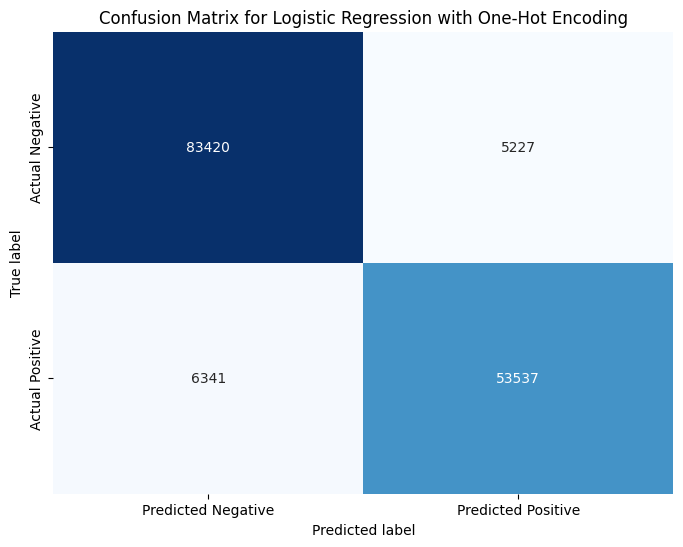

In [161]:
# prompt: costruisci una confusion matrix di log_reg_OH con i colori

import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set using the log_reg_OH pipeline
y_pred_OH_QT = log_reg_OH_QT.predict(data_test_x)

# Calculate the confusion matrix for log_reg_OH
cm_OH_QT = confusion_matrix(data_test_y, y_pred_OH_QT)

# Plot the confusion matrix with colors
plt.figure(figsize=(8, 6))
sns.heatmap(cm_OH_QT, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Logistic Regression with One-Hot Encoding')
plt.show()


## Analisi coefficienti

In [163]:
# prompt: printa i coefficienti della regressione logistica log_reg_OH_QT e le feature corrispondenti

# Get the Logistic Regression model from the pipeline
log_reg_model_OH_QT = log_reg_OH_QT.named_steps['logisticregression']

# Get the coefficients
coefficients_OH_QT = log_reg_model_OH_QT.coef_[0]

# Get the intercept
intercept_OH_QT = log_reg_model_OH_QT.intercept_[0]

# Print the coefficients and corresponding feature names
print("Intercept:", intercept_OH_QT)
print("\nCoefficients:")
for feature, coef in zip(all_processed_feature_names, coefficients_OH_QT):
    print(f"{feature}: {coef:.4f}")

Intercept: 21.833821520617697

Coefficients:
indicated_air_speed_binned_5_quantile_0: 4.9335
indicated_air_speed_binned_5_quantile_1: 5.1127
indicated_air_speed_binned_5_quantile_2: 4.4089
indicated_air_speed_binned_5_quantile_3: 3.9131
indicated_air_speed_binned_5_quantile_4: 3.3294
outside_air_temp: -51.3555
power_avail_root_2.35_transformed: -36.3642
pca_net_power_compressor_speed: 46.5863
torque_times_temp: -10.6723


In [164]:
# prompt: printa i coefficienti della regressione logistica log_reg_OH_QT

import pandas as pd
# Access the Logistic Regression model from the pipeline
log_reg_model_OH_QT = log_reg_OH_QT.named_steps['logisticregression']

# Check if the model has coefficients (LogisticRegression does)
if hasattr(log_reg_model_OH_QT, 'coef_'):
    print("Coefficients of the Logistic Regression Model (log_reg_OH_QT):")
    # Print the coefficients and potentially the intercept
    print("Coefficients:", log_reg_model_OH_QT.coef_[0]) # For binary classification, coef_ is usually shape (1, n_features)
    print("Intercept:", log_reg_model_OH_QT.intercept_[0]) # For binary classification, intercept_ is usually shape (1,)

    # To see which coefficient corresponds to which feature, we need the feature names
    # after the preprocessing step.
    # The column names are stored in `all_processed_feature_names` after creating
    # `data_train_processed_x_OH_QT`.

    if len(log_reg_model_OH_QT.coef_[0]) == len(all_processed_feature_names):
        coefficients_df = pd.DataFrame({
            'Feature': all_processed_feature_names,
            'Coefficient': log_reg_model_OH_QT.coef_[0]
        })
        print("\nFeature Coefficients:")
        print(coefficients_df)
    else:
        print("\nWarning: Number of coefficients does not match the number of processed features.")
        print("Number of coefficients:", len(log_reg_model_OH_QT.coef_[0]))
        print("Number of processed features:", len(all_processed_feature_names))

else:
    print("The fitted model does not have 'coef_' attribute (e.g., not a linear model).")

Coefficients of the Logistic Regression Model (log_reg_OH_QT):
Coefficients: [  4.93349092   5.11268058   4.40885737   3.91307927   3.32940666
 -51.35550875 -36.3641836   46.58630479 -10.67233501   8.44570008]
Intercept: 21.833821520617697

Number of coefficients: 10
Number of processed features: 9


In [165]:
data_train_y

,y_target
331067,1
601458,0
77053,0
664037,0
346977,1
...,...
259178,0
365838,1
131932,1
671155,1


Dall'analisi dei coefficienti si nota come abbia molto peso mean_gas_temp e torque_times_temp

### Odds ratio e p value

In [168]:
# prompt: analizza l'odds ratio associati a log_reg_OH_QT

import pandas as pd
import numpy as np
# To analyze odds ratios, we need the coefficients from the logistic regression model.
# The odds ratio for a feature is calculated as exp(coefficient).
# A p-value for each coefficient is typically obtained using statistical libraries
# like statsmodels, which provides more detailed statistical summaries for GLMs.

import statsmodels.api as sm

# The LogisticRegression from scikit-learn does not directly provide p-values.
# We need to refit the model using statsmodels.
# Statsmodels expects the data in a specific format and often requires adding a constant for the intercept.

# Get the preprocessed data used to train the log_reg_OH_QT pipeline
# We can transform the original training data using the preprocessing pipeline.
# Note: The `to_dataframe` function already produces the preprocessed DataFrame.
# We need the one associated with `preprocessing_OH_QT`.
X_train_processed_OH_QT_sm = data_train_processed_OH_QT.copy()
y_train_sm = data_train_y.copy()

# Add a constant (intercept) to the features DataFrame for statsmodels
X_train_processed_OH_QT_sm = sm.add_constant(X_train_processed_OH_QT_sm)

# Fit the logistic regression model using statsmodels
# Note: In statsmodels, the target variable (y) comes first.
try:
    sm_log_reg_OH_QT = sm.Logit(y_train_sm, X_train_processed_OH_QT_sm).fit()

    # Print the summary which includes coefficients, standard errors, z-scores, p-values, and confidence intervals
    print(sm_log_reg_OH_QT.summary())

    # Calculate and print the Odds Ratios
    # Odds Ratio = exp(Coefficient)
    # For the constant term, the interpretation is different (it's the odds when all predictors are zero).
    # We usually focus on the odds ratios for the features.
    odds_ratios_OH_QT = pd.DataFrame({
        'Feature': X_train_processed_OH_QT_sm.columns,
        'Coefficient': sm_log_reg_OH_QT.params,
        'Odds Ratio': np.exp(sm_log_reg_OH_QT.params),
        'P-value': sm_log_reg_OH_QT.pvalues
    })

    print("\nOdds Ratios and P-values:")
    print(odds_ratios_OH_QT)

except Exception as e:
    print(f"An error occurred during statsmodels fitting: {e}")
    print("Check the input data for issues (e.g., perfect multicollinearity).")


Optimization terminated successfully.
         Current function value: 0.211920
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               y_target   No. Observations:               594100
Model:                          Logit   Df Residuals:                   594090
Method:                           MLE   Df Model:                            9
Date:                Sat, 31 May 2025   Pseudo R-squ.:                  0.6857
Time:                        13:23:10   Log-Likelihood:            -1.2590e+05
converged:                       True   LL-Null:                   -4.0059e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      23.0333

Dall'analisi del p-value risulta come le 4 feature numeriche risultino correlate all'uscita (p-value inferiore a 0.05).

C'è una correlazione molto forte con power_available

## Curva ROC

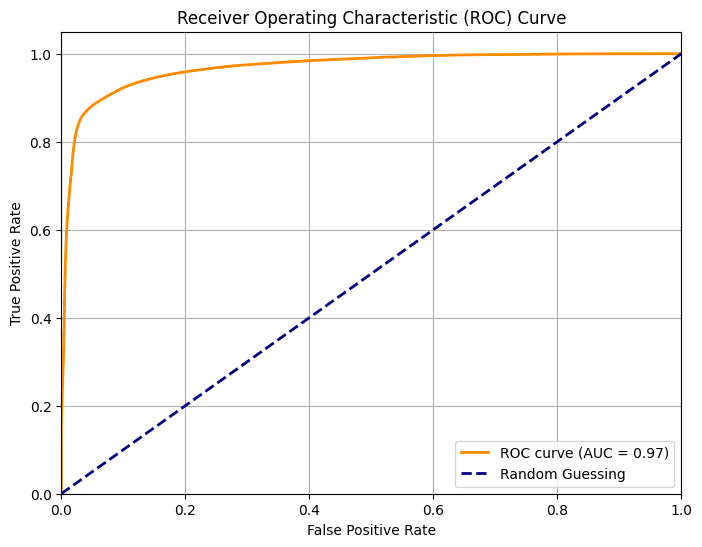

Area Under the ROC Curve (AUC): 0.9687


In [110]:
# prompt: plotta la curva AUC

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class (class 1)
y_prob = log_reg_OH_CH.predict_proba(data_test_x)[:, 1]

# Calculate the false positive rate (fpr) and true positive rate (tpr) for various thresholds
fpr, tpr, thresholds = roc_curve(data_test_y, y_prob)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing') # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Area Under the ROC Curve (AUC): {roc_auc:.4f}")


## Lasso regression

Lasso-regularized Logistic Regression pipeline fitted.

Evaluation Metrics for Lasso-regularized Logistic Regression:
Confusion Matrix:
[[70895 17752]
 [19680 40198]]

Accuracy: 0.7480
Precision: 0.6937
Sensitivity (Recall): 0.6713
Specificity: 0.7997

Coefficients of the Lasso-regularized Logistic Regression Model:
Coefficients: [ 1.0367422   0.93780992  0.29849697 -0.34151237 -0.23954426 -8.55877566
  5.44025879  1.057287   -0.21106469]
Intercept: 0.5191634232421661

Feature Coefficients (Lasso, Sorted by Absolute Value):
                                   Feature  Coefficient
5                         outside_air_temp    -8.558776
6        power_avail_root_2.35_transformed     5.440259
7           pca_net_power_compressor_speed     1.057287
0  indicated_air_speed_binned_5_quantile_0     1.036742
1  indicated_air_speed_binned_5_quantile_1     0.937810
3  indicated_air_speed_binned_5_quantile_3    -0.341512
2  indicated_air_speed_binned_5_quantile_2     0.298497
4  indicated_air_speed

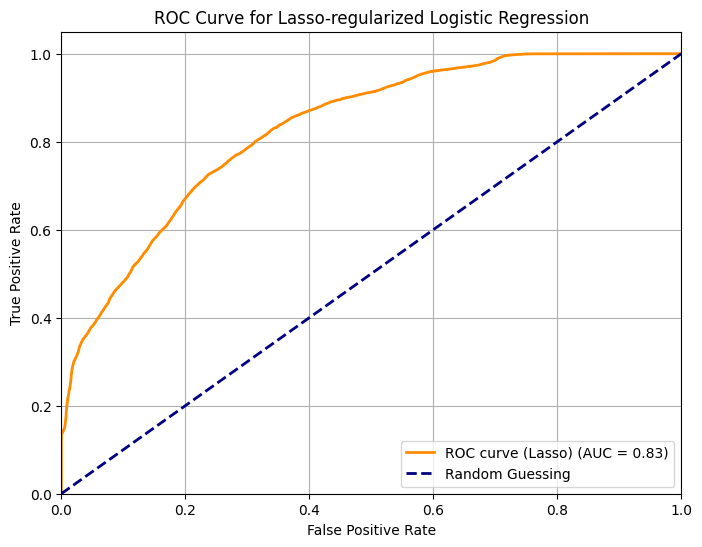


Area Under the ROC Curve (AUC) for Lasso: 0.8305


In [111]:
# prompt: prova ad usare la lasso regression per trovare la funzione di regressione logistica

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression



# Define the Logistic Regression model with Lasso (L1) penalty
log_reg_lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42) # C=1.0 is a common starting point

# Integrate this model into the pipeline with OneHotEncoding
# We will replace the standard LogisticRegression step with the Lasso-regularized one.
log_reg_lasso_OH_CH_pipeline = make_pipeline(preprocessing_OH_CH, log_reg_lasso_model)

# Fit the pipeline to the training data
# Note: The preprocessing_OH pipeline is assumed to be defined and fitted already based on the preceding code.
# If you run this code block independently, make sure preprocessing_OH is available and fitted.
log_reg_lasso_OH_CH_pipeline.fit(data_train_x, data_train_y)

print("Lasso-regularized Logistic Regression pipeline fitted.")

# You can now use log_reg_lasso_OH_CH_pipeline for predictions and evaluation
# Make predictions on the test set
y_pred_lasso = log_reg_lasso_OH_CH_pipeline.predict(data_test_x)

# Evaluate the model (using confusion matrix, accuracy, etc. as done previously)
cm_lasso = confusion_matrix(data_test_y, y_pred_lasso)
tn_lasso, fp_lasso, fn_lasso, tp_lasso = cm_lasso.ravel()

accuracy_lasso = accuracy_score(data_test_y, y_pred_lasso)
precision_lasso = precision_score(data_test_y, y_pred_lasso)
sensitivity_lasso = recall_score(data_test_y, y_pred_lasso)
specificity_lasso = tn_lasso / (tn_lasso + fp_lasso) if (tn_lasso + fp_lasso) > 0 else 0

print("\nEvaluation Metrics for Lasso-regularized Logistic Regression:")
print("Confusion Matrix:")
print(cm_lasso)
print(f"\nAccuracy: {accuracy_lasso:.4f}")
print(f"Precision: {precision_lasso:.4f}")
print(f"Sensitivity (Recall): {sensitivity_lasso:.4f}")
print(f"Specificity: {specificity_lasso:.4f}")

# Analyze coefficients (Lasso regularization tends to push some coefficients to exactly zero)
log_reg_lasso_model_fitted = log_reg_lasso_OH_CH_pipeline.named_steps['logisticregression']

if hasattr(log_reg_lasso_model_fitted, 'coef_'):
    print("\nCoefficients of the Lasso-regularized Logistic Regression Model:")
    print("Coefficients:", log_reg_lasso_model_fitted.coef_[0])
    print("Intercept:", log_reg_lasso_model_fitted.intercept_[0])

    # To see which coefficient corresponds to which feature
    # We need the column names after preprocessing, which are in all_processed_feature_names
    if len(log_reg_lasso_model_fitted.coef_[0]) == len(all_processed_feature_names):
        coefficients_lasso_df = pd.DataFrame({
            'Feature': all_processed_feature_names,
            'Coefficient': log_reg_lasso_model_fitted.coef_[0]
        })
        # Sort by absolute coefficient value to see the most important features
        coefficients_lasso_df['Abs_Coefficient'] = np.abs(coefficients_lasso_df['Coefficient'])
        coefficients_lasso_df_sorted = coefficients_lasso_df.sort_values(by='Abs_Coefficient', ascending=False).drop(columns='Abs_Coefficient')

        print("\nFeature Coefficients (Lasso, Sorted by Absolute Value):")
        print(coefficients_lasso_df_sorted)

        # Count how many coefficients are exactly zero
        zero_coefficients_count = (coefficients_lasso_df['Coefficient'] == 0).sum()
        print(f"\nNumber of coefficients exactly zero (due to L1 regularization): {zero_coefficients_count}")

    else:
        print("\nWarning: Number of coefficients does not match the number of processed features.")

# Plot ROC Curve for Lasso model
y_prob_lasso = log_reg_lasso_OH_CH_pipeline.predict_proba(data_test_x)[:, 1]
fpr_lasso, tpr_lasso, thresholds_lasso = roc_curve(data_test_y, y_prob_lasso)
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lasso, tpr_lasso, color='darkorange', lw=2, label=f'ROC curve (Lasso) (AUC = {roc_auc_lasso:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Lasso-regularized Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nArea Under the ROC Curve (AUC) for Lasso: {roc_auc_lasso:.4f}")


Peggiora le prestazioni.

## Ridge regression

Ridge-regularized Logistic Regression pipeline fitted using preprocessing_OH_CH.

Evaluation Metrics for Ridge-regularized Logistic Regression:
Confusion Matrix:
[[70899 17748]
 [19684 40194]]

Accuracy: 0.7480
Precision: 0.6937
Sensitivity (Recall): 0.6713
Specificity: 0.7998

Coefficients of the Ridge-regularized Logistic Regression Model:

Feature Coefficients (Ridge, Sorted by Absolute Value):
                                   Feature  Coefficient
5                         outside_air_temp    -8.554774
6        power_avail_root_2.35_transformed     5.437256
7           pca_net_power_compressor_speed     1.056857
0  indicated_air_speed_binned_5_quantile_0     0.841147
1  indicated_air_speed_binned_5_quantile_1     0.742140
3  indicated_air_speed_binned_5_quantile_3    -0.536659
4  indicated_air_speed_binned_5_quantile_4    -0.434547
8                        torque_times_temp    -0.212639
2  indicated_air_speed_binned_5_quantile_2     0.102952


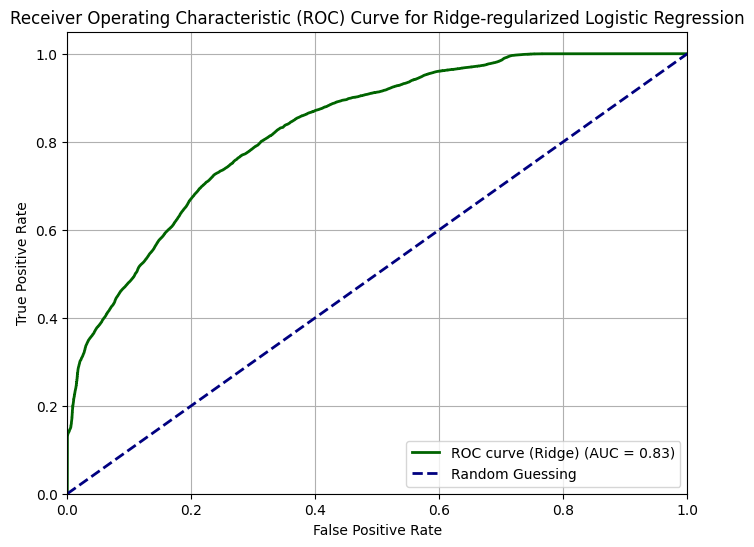


Area Under the ROC Curve (AUC) for Ridge: 0.8305


In [47]:
# prompt: Applica la ridge regression

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Define the Logistic Regression model with Ridge (L2) penalty
log_reg_ridge_model = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, random_state=42) # C=1.0 is a common starting point, solver='liblinear' works with l2

# Integrate this model into the pipeline with OneHotEncoding and chosen feature engineering
# We will use the preprocessing_OH_CH pipeline which performed better in the previous analysis.
# Replace the standard LogisticRegression step with the Ridge-regularized one.
log_reg_ridge_OH_CH_pipeline = make_pipeline(preprocessing_OH_CH, log_reg_ridge_model)

# Fit the pipeline to the training data
log_reg_ridge_OH_CH_pipeline.fit(data_train_x, data_train_y)

print("Ridge-regularized Logistic Regression pipeline fitted using preprocessing_OH_CH.")

# You can now use log_reg_ridge_OH_CH_pipeline for predictions and evaluation
# Make predictions on the test set
y_pred_ridge = log_reg_ridge_OH_CH_pipeline.predict(data_test_x)

# Evaluate the model (using confusion matrix, accuracy, etc. as done previously)
cm_ridge = confusion_matrix(data_test_y, y_pred_ridge)
tn_ridge, fp_ridge, fn_ridge, tp_ridge = cm_ridge.ravel()

accuracy_ridge = accuracy_score(data_test_y, y_pred_ridge)
precision_ridge = precision_score(data_test_y, y_pred_ridge)
sensitivity_ridge = recall_score(data_test_y, y_pred_ridge)
specificity_ridge = tn_ridge / (tn_ridge + fp_ridge) if (tn_ridge + fp_ridge) > 0 else 0

print("\nEvaluation Metrics for Ridge-regularized Logistic Regression:")
print("Confusion Matrix:")
print(cm_ridge)
print(f"\nAccuracy: {accuracy_ridge:.4f}")
print(f"Precision: {precision_ridge:.4f}")
print(f"Sensitivity (Recall): {sensitivity_ridge:.4f}")
print(f"Specificity: {specificity_ridge:.4f}")

# Analyze coefficients (Ridge regularization shrinks coefficients towards zero but doesn't make them exactly zero)
log_reg_ridge_model_fitted = log_reg_ridge_OH_CH_pipeline.named_steps['logisticregression']

if hasattr(log_reg_ridge_model_fitted, 'coef_'):
    print("\nCoefficients of the Ridge-regularized Logistic Regression Model:")
    # Use all_processed_feature_names obtained from the previous cell
    if len(log_reg_ridge_model_fitted.coef_[0]) == len(all_processed_feature_names):
        coefficients_ridge_df = pd.DataFrame({
            'Feature': all_processed_feature_names,
            'Coefficient': log_reg_ridge_model_fitted.coef_[0]
        })
        # Sort by absolute coefficient value
        coefficients_ridge_df['Abs_Coefficient'] = np.abs(coefficients_ridge_df['Coefficient'])
        coefficients_ridge_df_sorted = coefficients_ridge_df.sort_values(by='Abs_Coefficient', ascending=False).drop(columns='Abs_Coefficient')

        print("\nFeature Coefficients (Ridge, Sorted by Absolute Value):")
        print(coefficients_ridge_df_sorted)

    else:
        print("\nWarning: Number of coefficients does not match the number of processed features.")
        print("Number of coefficients:", len(log_reg_ridge_model_fitted.coef_[0]))
        print("Number of processed features:", len(all_processed_feature_names))

else:
    print("The fitted model does not have 'coef_' attribute.")


# Plot ROC Curve for Ridge model
y_prob_ridge = log_reg_ridge_OH_CH_pipeline.predict_proba(data_test_x)[:, 1]
fpr_ridge, tpr_ridge, thresholds_ridge = roc_curve(data_test_y, y_prob_ridge)
roc_auc_ridge = auc(fpr_ridge, tpr_ridge)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ridge, tpr_ridge, color='darkgreen', lw=2, label=f'ROC curve (Ridge) (AUC = {roc_auc_ridge:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Ridge-regularized Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nArea Under the ROC Curve (AUC) for Ridge: {roc_auc_ridge:.4f}")


Sia la ridge che la lasso regression peggiorano le prestazioni. Questo è dovuto al fatto che tutte le feature sono determinanti per predire lo stato di salute.

## Analisi risultati

La lasso regression peggiora le performance

## Tuning dei parametri

In [53]:
# prompt: esegui un'operazione di fine tuning sui parametri di log_reg_OH_CH

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to tune for the Logistic Regression step
# The parameter names in the grid must be prefixed with the name of the step in the pipeline ('logisticregression')
# followed by a double underscore '__' and the parameter name.
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100], # Inverse of regularization strength; smaller values specify stronger regularization.
    'logisticregression__penalty': ['l2'], # Regularization type. 'l1' can also be used, but requires 'liblinear' solver for some versions. 'l2' is standard.
    'logisticregression__solver': ['lbfgs', 'liblinear'], # Algorithm to use in the optimization problem. 'liblinear' is good for small datasets, 'lbfgs' is generally faster for larger ones and supports 'l2'.
    'logisticregression__max_iter': [1000, 2000, 3000] # Maximum number of iterations for the solver to converge.
}

# Create a GridSearchCV object
# estimator: Your pipeline (log_reg_OH_CH)
# param_grid: The dictionary of parameters to tune
# cv: Number of cross-validation folds (e.g., 5 or 10)
# scoring: The metric to optimize (e.g., 'accuracy', 'precision', 'recall', 'f1', 'roc_auc')
# n_jobs: Number of CPU cores to use (-1 means all available cores)
# verbose: Controls the verbosity: higher values mean more output during the process.
grid_search = GridSearchCV(estimator=log_reg_OH_CH,
                           param_grid=param_grid,
                           cv=5, # Using 5 folds for cross-validation
                           scoring='roc_auc', # Optimizing for AUC, as it considers the trade-off between sensitivity and specificity
                           n_jobs=-1, # Use all available cores
                           verbose=2) # Print progress messages

# Fit GridSearchCV on the training data (features and target)
# GridSearchCV will automatically apply the pipeline's preprocessing steps within each fold.
grid_search.fit(data_train_x, data_train_y)

# Get the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Get the best estimator (the pipeline with the best parameters)
best_log_reg_OH_CH = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_best = best_log_reg_OH_CH.predict(data_test_x)
y_prob_best = best_log_reg_OH_CH.predict_proba(data_test_x)[:, 1]

# Calculate and print metrics for the best model on the test set
cm_best = confusion_matrix(data_test_y, y_pred_best)
tn_best, fp_best, fn_best, tp_best = cm_best.ravel()

accuracy_best = accuracy_score(data_test_y, y_pred_best)
precision_best = precision_score(data_test_y, y_pred_best)
sensitivity_best = recall_score(data_test_y, y_pred_best)
specificity_best = tn_best / (tn_best + fp_best) if (tn_best + fp_best) > 0 else 0
roc_auc_best = auc(roc_curve(data_test_y, y_prob_best)[0], roc_curve(data_test_y, y_prob_best)[1])


print("\nMetrics for the Best Model (after GridSearchCV) on the Test Set:")
print("Confusion Matrix:")
print(cm_best)
print(f"\nAccuracy: {accuracy_best:.4f}")
print(f"Precision: {precision_best:.4f}")
print(f"Sensitivity (Recall): {sensitivity_best:.4f}")
print(f"Specificity: {specificity_best:.4f}")
print(f"Area Under the ROC Curve (AUC): {roc_auc_best:.4f}")

# Optional: Plot Confusion Matrix and ROC Curve for the best model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Best Logistic Regression Model (after GridSearchCV)')
plt.show()

fpr_best, tpr_best, thresholds_best = roc_curve(data_test_y, y_prob_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Best Logistic Regression Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Fitting 5 folds for each of 36 candidates, totalling 180 fits


KeyboardInterrupt: 

Ci mette 4 minuti

Il tuning dei parametri non ha migliorato gli indici. Ha comportato un lieve peggioramento.

## Randomized Search

In [54]:
# prompt: utilizza RandomsizedSearchcV

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'logisticregression__C': np.logspace(-3, 2, 6),
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['lbfgs', 'liblinear'],
    'logisticregression__max_iter': [1000, 2000, 3000, 5000],
}


random_search = RandomizedSearchCV(estimator=log_reg_OH,
                                   param_distributions=param_dist,
                                   n_iter=48,
                                   cv=3,
                                   scoring='roc_auc',
                                   n_jobs=-1,
                                   random_state=42,
                                   verbose=2)


random_search.fit(data_train_x, data_train_y)


print("Best parameters found by RandomizedSearchCV:")
print(random_search.best_params_)




Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters found by RandomizedSearchCV:
{'logisticregression__solver': 'lbfgs', 'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 1000, 'logisticregression__C': np.float64(100.0)}


In [55]:
final_model = random_search.best_estimator_


## Valuto la performance del nuovo modello


Metrics for the Final Model (from RandomizedSearchCV) on the Test Set:
Confusion Matrix:
[[77265 11382]
 [14971 44907]]

Accuracy: 0.8226
Precision: 0.7978
Sensitivity (Recall): 0.7500
Specificity: 0.8716
Area Under the ROC Curve (AUC): 0.8999


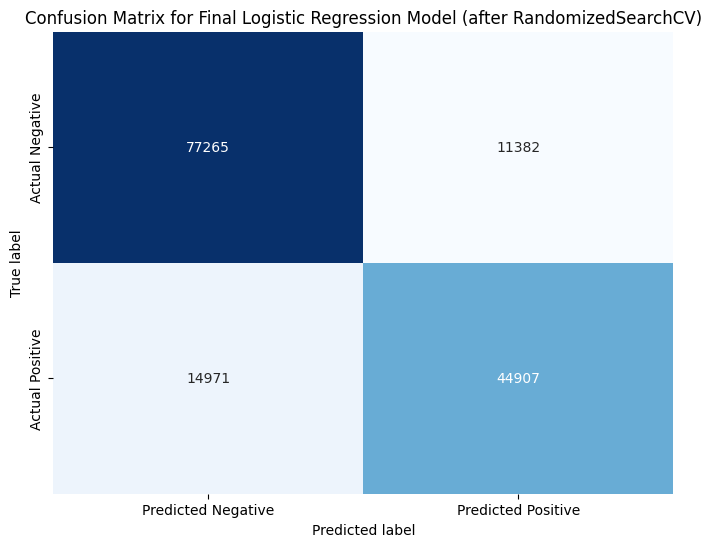

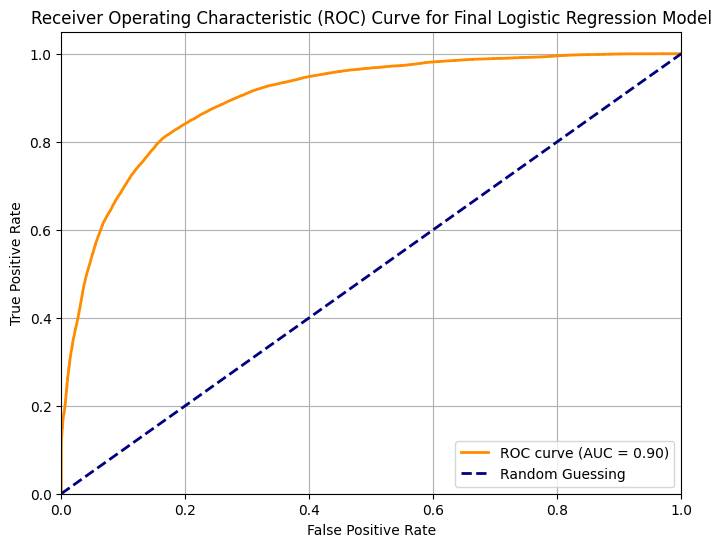

In [56]:
# prompt: valuta le performance di final model su test

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# The code for evaluating the final_model on the test set is already present in the preceding code.
# You just need to run the last few cells of the provided code block.

# Evaluate the final_model (which is the best_estimator_ from RandomizedSearchCV) on the test set
y_pred_final = final_model.predict(data_test_x)
y_prob_final = final_model.predict_proba(data_test_x)[:, 1]

# Calculate and print metrics for the final_model on the test set
cm_final = confusion_matrix(data_test_y, y_pred_final)
tn_final, fp_final, fn_final, tp_final = cm_final.ravel()

accuracy_final = accuracy_score(data_test_y, y_pred_final)
precision_final = precision_score(data_test_y, y_pred_final)
sensitivity_final = recall_score(data_test_y, y_pred_final)
specificity_final = tn_final / (tn_final + fp_final) if (tn_final + fp_final) > 0 else 0
roc_auc_final = auc(roc_curve(data_test_y, y_prob_final)[0], roc_curve(data_test_y, y_prob_final)[1])

print("\nMetrics for the Final Model (from RandomizedSearchCV) on the Test Set:")
print("Confusion Matrix:")
print(cm_final)
print(f"\nAccuracy: {accuracy_final:.4f}")
print(f"Precision: {precision_final:.4f}")
print(f"Sensitivity (Recall): {sensitivity_final:.4f}")
print(f"Specificity: {specificity_final:.4f}")
print(f"Area Under the ROC Curve (AUC): {roc_auc_final:.4f}")

# Optional: Plot Confusion Matrix and ROC Curve for the final model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Final Logistic Regression Model (after RandomizedSearchCV)')
plt.show()

fpr_final, tpr_final, thresholds_final = roc_curve(data_test_y, y_prob_final)
plt.figure(figsize=(8, 6))
plt.plot(fpr_final, tpr_final, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_final:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Final Logistic Regression Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Noto un peggioramento delle prestazioni